# Ancient texts: Counts, Frequencies, and Weights
### This notebook contains
Modern sentiment analyses performed on translations of an ancient text corpus\
For a discussion of the original data set see the notebook Ancient texts: Exploratory Data Analysis (EDA) and preparation

### Goal
**To discover if calculating most used or highest weighted terms and phrases can**
1. Provide insights into sentiment/polarity results (see notebook Ancient texts: Get sentiment)
2. Provide additional insights into sets of texts divided by genre, god, and person

*Specifically*
* Help identify why a sentiment score was reached (for example: repeated negative phrases would indicate an overall negative tone)
* Reveal trends by group
  * differences between genres or god or person featured text groups 
* Reveal misidentifications if certain phraseology is more present in one group than another
* Help in predictive analyses as n-grams will serve as more granular features to aid in classification

### Data
`all_texts_sentiment.csv`

This cleaned df contains 381 observations with 19 features\
Features from the original df `cat_with_ALL_texts.csv` are: `A_category`, `B_category`, `Period`, `Dynasty`, `God`, `2nd_god`, `Other_divine`, `Person`, `Number`, `Title`, `Place`, and `Text`

Features created for `all_texts_sentiment.csv` were: `American`, `cleaned_sentences`, `agg_polarity`, `agg_subjectivity`, `joined_text`, `whole_polarity`, and `whole_subjectivity`

*What's in them*
* `American` contains the original British translations stored in `Text` Americanized 
* `cleaned_sentences` contains cleaned Americanized text
  * basic cleaning such as sentence tokenization, lowercasing, & the removal of certain words/notations
  * results originally a list of sentences in each value
  * since save to a csv, some value formats have been altered
* `agg_polarity` and `agg_subjectivity` contain the aggregated polarity and subjectivity scores
  * polarity/subjectivity scores for each sentence in `cleaned_sentences` were assesed, totaled, and then averaged 
* `joined_text` contains `cleaned_sentences` joined
* `whole_polarity` and `whole_subjectivity` contain whole assessment scores for each `joined_text`

### Steps taken in this notebook
1. **Text Preparation for Analysis**
   - Utilize regex and WordNetLemmatizer on `joined_text` to prepare text
   - Create new feature `lemmatized`
<br>
<br>
2.	**Word Count Analysis**
   - Develop feature `word_count` to calculate length of text in `lemmatized`
   - Compute mean and median word counts categorized by `B_category`, `God`, and `Person`
   - Generate some visual representations of word counts as examples
<br>
<br>
3.	**Token Count Calculation**
   - Establish feature `token_count` using nltk.tokenizer.word_tokenize() to identify top 5 tokens within text
   - Saved as `all_texts_processed.csv`
<br>
<br>
4.	**Frequency Distribution Visualization**
   - Create frequency distribution graph using nltk.FreqDist()
   - Introduce feature `split_tokens` for further analysis
<br>
<br>
5.	**N-gram Extraction Using TfidfVectorizer**
   - Employ TfidfVectorizer to extract bi-grams and tri-grams from texts
   - Construct dictionaries for bi-grams and tri-grams, grouping words by their initial letter
   - Identify top bi-grams and tri-grams for all texts in `Text`
   - Analyze top bi-grams and tri-grams by features `B_category`, `God`, and `Person`

In [1]:
# Import standard operational packages
import numpy as np
import pandas as pd

# Import NLP packages
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import Counter
import string

# Import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Import counts and weights packages
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /Users/ilona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ilona/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Import csv
df0 = pd.read_csv('all_texts_sentiment.csv')
df0.head(2)

,A_category,B_category,Period,Dynasty,God,2nd_god,Other_divine,Person,Number,Title,Place,Text,American,cleaned_sentences,agg_polarity,agg_subjectivity,joined_text,whole_polarity,whole_subjectivity
0,Narrative and mythological compositions,Narratives featuring deities,NaN,NaN,Enki,Ninhursaga,NaN,NaN,1.1.1,Enki and Ninhursaga,NaN,1-4. Pure are the cities -- and you are the o...,1-4. pure are the cities -- and you are the o...,[' pure are the cities; and you are the ones t...,0.115145,0.199539,pure are the cities; and you are the ones to ...,0.330364,0.559201
1,Narrative and mythological compositions,Narratives featuring deities,NaN,NaN,Enki,Ninmah,NaN,NaN,1.1.2,Enki and Ninmah,NaN,"1-11. In those days, in the days when heaven ...","1-11. in those days, in the days when heaven ...","[' in those days, in the days when heaven and ...",0.058195,0.239558,"in those days, in the days when heaven and ea...",0.110600,0.449011


In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   A_category          381 non-null    object 
 1   B_category          381 non-null    object 
 2   Period              151 non-null    object 
 3   Dynasty             151 non-null    object 
 4   God                 238 non-null    object 
 5   2nd_god             10 non-null     object 
 6   Other_divine        28 non-null     object 
 7   Person              184 non-null    object 
 8   Number              381 non-null    object 
 9   Title               381 non-null    object 
 10  Place               28 non-null     object 
 11  Text                381 non-null    object 
 12  American            381 non-null    object 
 13  cleaned_sentences   381 non-null    object 
 14  agg_polarity        381 non-null    float64
 15  agg_subjectivity    381 non-null    float64
 16  joined_t

In [4]:
df0.columns

Index(['A_category', 'B_category', 'Period', 'Dynasty', 'God', '2nd_god',
       'Other_divine', 'Person', 'Number', 'Title', 'Place', 'Text',
       'American', 'cleaned_sentences', 'agg_polarity', 'agg_subjectivity',
       'joined_text', 'whole_polarity', 'whole_subjectivity'],
      dtype='object')

### Check out a text and its polarity and subjectivity scores
**Polarity** measures the sentiment expressed in a piece of text
* It indicates whether the sentiment is positive, negative, or neutral
* Scores range from -1 (negative) to 1 (positive)

**Subjectivity** measures the degree to which a text expresses personal opinions, feelings, or beliefs, as opposed to objective facts
* Scores range from 0 (factual) to 1 (subjective)

In [5]:
# Examine scores and a text in `joined_text`
print('Title:', df0.iloc[122, 9])
print('The agg_polarity score is', df0.iloc[122, 14].round(2), 'and the agg_subjectivity score is', df0.iloc[122, 15].round(2))
print('The whole_polarity score is', df0.iloc[122, 17].round(2), 'and the whole_subjectivity score is', df0.iloc[122, 18].round(2))
df0.iloc[122, 16]

Title: A hymn to Inana for Ishme-Dagan
The agg_polarity score is 0.02 and the agg_subjectivity score is 0.04
The whole_polarity score is 0.23 and the whole_subjectivity score is 0.35


"   …… squatting in the dust ……. …… of inana ……. …… of her garment of ladyship. …… with blood. …… her submission ……. …… insulted ……, cursed my temple. …… i despised him. …… cursed my city. …… devastated my ……. …… sullied my garments. …… rites ……. thus …… my mood and heart. as if during the night watch …… like excrement. …… my countenance like smoke. …… my body like blazing straw. …… kirugu. …… lady ……. its ĝišgiĝal. …… whose hands were fettered, …… who had been treated unjustly. the son of enlil, the son of ……. …… sumer ……. i, enlil, ……. from now on ……. he made the people follow the proper path, and ousted the enemy from sumer. he removed the wicked tongues, and made justice shine forth like copper. that fathers should be feared and mothers respected, that sons should pay heed to the words of their fathers, and that mercy, compassion and pity should be shown, that one should provide even one's paternal grandparents with food and drink; all this he established in sumer and akkad. then s

##### Note 
A hymn to Inana for Ishme-Dagan is a slightly positive and slightly subjective text according to the whole method. It is a predominantly factual and neutral text using the aggregated method. One would think that the text would be scored more negatively with phrases like "squatting in the dust" and words like excrement and fettered. Will be interesting to see what words in this text are deemed to carry the most weight and count. 

#### Streamline columns for analysis

In [6]:
# Select columns
df = df0[['B_category', 'God', 'Number', 'Person', 'Title', 'joined_text']].reset_index(drop=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   B_category   381 non-null    object
 1   God          238 non-null    object
 2   Number       381 non-null    object
 3   Person       184 non-null    object
 4   Title        381 non-null    object
 5   joined_text  381 non-null    object
dtypes: object(6)
memory usage: 18.0+ KB
None


,B_category,God,Number,Person,Title,joined_text
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea..."
2,Narratives featuring deities,Enki,1.1.3,NaN,Enki and the world order,"grandiloquent lord of heaven and earth, self-..."
3,Narratives featuring deities,Enki,1.1.4,NaN,Enki's journey to Nibru,"in those remote days, when the fates were det..."
4,Narratives featuring deities,Enlil,1.2.1,NaN,Enlil and Ninlil,"there was a city, there was a city; the one w..."


In [7]:
# Check for nulls
df.isna().any()

B_category     False
God             True
Number         False
Person          True
Title          False
joined_text    False
dtype: bool

#### Examine feature contents

#### God

In [8]:
print(df['God'].nunique())
df['God'].unique()

46


array(['Enki', 'Enlil', 'Inana', 'Inana and Dumuzid', 'Nanna-Suen',
       'Ninurta', 'Martu', 'Ningishzida', 'Gods', nan, 'Pabilsag', 'Bau',
       'Nanna', 'Utu', 'Ninlil', 'Nergal', 'An', 'Suen', 'Meshlamta-ea',
       'Kindattu', 'Nanaya', 'Ninisina', 'Ninsiana', 'Ningublaga',
       'Nuska', 'Dagan', 'Ishkur', 'Numushda', 'Haia', 'Asarluhi',
       'Marduk', 'Nintinuga', 'personal deity', 'Ninshubur', 'Damgalnuna',
       'Hendursaga', 'Nanshe', 'Ninazu', 'Ninimma', 'Ninkasi', 'Nintur',
       'Nisaba', 'Nungal', 'Shara', 'Shul-pa-e', 'Sadarnuna', 'Kusu'],
      dtype=object)

#### Genre

In [9]:
print(df['B_category'].nunique())
df['B_category'].unique()

25


array(['Narratives featuring deities', 'Narratives featuring heroes',
       'King lists and other compositions', 'City laments',
       'Royal praise poetry and hymns to deities on behalf of rulers',
       'Praise poetry and hymns for unknown rulers',
       'Royal correspondence', 'Other letters and letter-prayers',
       'Hymns addressed to deities',
       'Hymns addressed to or concerning temples', 'School stories',
       'Debate poems', 'Dialogues and diatribes', 'Personal laments',
       'Reflective compositions', 'Lu-digira compositions',
       'Types of song', 'Didactic compositions', 'Short tales',
       'Offering compositions', 'Other', 'Lexical compositions',
       'Animal fables', 'Proverb collections', 'Other proverbs'],
      dtype=object)

#### Person

In [10]:
print(df['Person'].nunique())
df['Person'].unique()

45


array([nan, 'Shu-kale-tuda', 'Geshtinana', 'Bilulu', 'Gilgamesh',
       'Lugalbanda', 'Enmerkar', 'Sargon', 'Utu-hegal', 'Gudea', 'Luma',
       'Ur-Namma', 'Shulgi', 'Amar-Suena', 'Shu-Suen', 'Ibbi-Suen',
       'Ishbi-Erra', 'Shu-ilishu', 'Iddin-Dagan', 'Ishme-Dagan',
       'Lipit-Eshtar', 'Ur-Ninurta', 'Bur-Suen', 'Enlil-bani', 'Gungunum',
       'Suen-iddinam', 'Suen-iqisham', 'Rim-Suen', 'Anam', 'Hammu-rabi',
       'Samsu-iluna', 'Abi-Eshuh', 'Ur-saga', 'Lugal-nesage', 'Ur-Enlila',
       'Aba-tah-lugalga', 'Ugubi', 'Shamash-tab', 'Inanaka', 'Inim-Inana',
       'Nanna-manshum', 'Inim-Enlila', 'Kug-Nanna', 'Enkimdu', 'Rulers',
       'Lu-digira'], dtype=object)

## Prepare text using feature `joined_text`
Sentences must be cleaned of non-words to count/weight meaningful words\
Because some of these are hymns and prayers it is interesting to include pronouns in counts, though perhaps obvious

* Define and remove stopwords
  * define a list of additional stopwords, because of nature of translation
  * union with stop words
  * define pronouns to keep
  * create function to remove pronouns to keep from stopwords because discard takes only 1 argument
* Define punctuation to be removed
* Create function `prepare_text`
  * remove custom stopwords and punctuation
  * word_tokenize
  * lemmatize tokens
  * join tokens 

In [11]:
# Define and remove stopwords
# Create loop, because discard takes only 1 argument
stop_words = set(stopwords.words('english'))

# Create a set of custom stop words
custom_stopwords = {'-……',
                    '…….',
                    '………',
                    '……', 
                    '--', 
                    '``', 
                    "'", 
                    '...', 
                    '..', 
                    ' l.', 
                    '...b', 
                    '...y', 
                    '...ni', 
                    '...c', 
                    '...d', 
                    '-',
                    'aa',
                    'yy',
                    'a', 
                    'b', 
                    'c', 
                    'd', 
                    'p.', 
                    'u',
                    'n',
                    'th',
                    'a-p.'}

# Union 'custom_stopwords' with stopwords 
extended_stopwords = stop_words.union(custom_stopwords)

# Create list of words to discard from stopwords (= to keep)
words_to_discard = ['i', 'you', 'not', 'she', 'he', 'they', 'we', 'us']

# Remove the specified stop words (words_to_discard)
for word in words_to_discard:
    extended_stopwords.discard(word)

print(extended_stopwords)

{'why', 'few', 'wasn', 'ourselves', '...b', 'didn', 'shouldn', "he's", 'its', "you're", 'b', 'are', "should've", 'than', 'when', '……', 'th', 'such', 'into', 'to', 'very', 'for', 'only', 'doing', '``', 're', 'is', 'nor', 'of', "aren't", 'her', "mustn't", 'yourself', ' l.', '………', 'his', 'mightn', 'a', "needn't", 'those', "she's", 'don', 'all', 'before', 'was', "we'll", 'during', 'each', '-……', 'that', 'can', "they've", "i've", '...', 'll', "couldn't", 'while', 'what', 'it', 'too', 'me', 'himself', "i'd", "hasn't", 'same', 'there', "you've", 'will', 'where', 'p.', 'y', 'c', 'further', 'which', "we'd", '..', 'their', 'needn', '...d', 'down', 'have', 'about', 'up', "don't", 'again', 'own', 'any', 'who', 'our', 'n', 'my', 'hers', 'them', "he'd", "won't", 'ma', 'with', 'how', 'some', "you'll", 'the', 'at', 'did', 'mustn', 'over', 'yy', 'just', 'him', 'isn', 'or', 'theirs', 'whom', 'and', 'your', 'hadn', 'having', "she'll", '...ni', "they're", 'wouldn', 'myself', 'weren', "it'd", 'no', 'more'

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
# Remove "-" from punctuation list, since it is a part of hypenated names
custom_punct = string.punctuation.replace('-', '')
custom_punct

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [14]:
# Create function 'prepare_text' that tokenizes, removes 'extended_stopwords', lemmatizes, & joins modified tokens 

def prepare_text(text):
    # Tokenize text
    tokens = word_tokenize(text) 

    # Remove stop words and punctuation
    filtered_tokens = [token for token in tokens if token not in extended_stopwords and
                       token not in custom_punct
                      ]
    
    # Lemmatize tokens
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Filter out tokens that are just an apostrophe or start with an apostrophe
    lemmatized_tokens = [token for token in lemmatized_tokens if not (token.startswith("'") or token == "'s" or token == "n't")]

    # Join tokens back into a spaced string 
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

In [15]:
# Apply 'prepare_text' to df
df_processed = df.copy()
df_processed['lemmatized'] = df_processed['joined_text'].apply(prepare_text)

In [16]:
df_processed.head(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...


In [17]:
# Examine a text in lemmatized
print(df_processed.iloc[125, 4])
df_processed.iloc[125, 6]

A praise poem of Lipit-Eshtar (Lipit-Eshtar B)


'lipit-eštar proud king enthroned prince seemly offshoot kingship walk like utu brilliant light land lofty nobility riding great divine power settle people four quarter favored enlil beloved ninlil trustworthy youth shining eye worthy throne-dais whose seemly head adorned tiara good heress hold hand perfect scepter black-headed prince lipit-eštar son enlil wise shepherd lead people let relax pleasant shade lord great bison beloved anu trust put mother ninlil lipit-eštar you exert great power you speak sweet honey whose name suit mouth longed-for husband inana enki gave broad wisdom gift nisaba woman radiant joy true woman scribe lady know everything guide finger clay she make put beautiful wedge tablet adorns golden stylus nisaba generously bestowed upon you measuring rod surveyor gleaming yardstick tablet confer wisdom lipit-eštar enlil son you realised justice righteousness lord goodness cover everything far horizon king lipit-eštar counsellor huge intelligence never tire discussion 

### Calculate lengths of texts
Create feature `word_count` using `lemmatized`
* Count words per text
  * find longest
  * find shortest
  * find median
  * find average length

In [18]:
# Get length of lemmatized texts
# Split text into words in order to count using .split() method
df_processed['word_count'] = [len(text.split()) for text in df_processed['lemmatized']]
df_processed.head(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...,1440
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...,825


#### Longest texts

In [19]:
# Get texts with highest word count
sorted_df = df_processed.sort_values(by='word_count', ascending=False).reset_index(drop=True)
sorted_df.head(4)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count
0,King lists and other compositions,Gods,2.1.7,Gudea,"The building of Ningirsu's temple (Gudea, cyli...",on the day when in heaven and earth the fates...,day heaven earth fate decided lagaš raised hea...,5305
1,Narratives featuring deities,Ninurta,1.6.2,NaN,Ninurta's exploits: a shir-sud (?) to Ninurta,"before anu, king of the gods, majestic one...",anu king god majestic one king storm majestic ...,3922
2,City laments,Gods,2.2.3,NaN,The lament for Sumer and Urim,"to overturn the appointed times, to obliterat...",overturn appointed time obliterate divine plan...,3050
3,Narratives featuring heroes,Gods,1.8.2.3,Enmerkar,Enmerkar and the lord of Aratta,"city, majestic bull bearing vigor and great a...",city majestic bull bearing vigor great awesome...,3028


#### Shortest texts

In [20]:
# Get texts with lowest word count
sorted_df = df_processed.sort_values(by='word_count', ascending=True).reset_index(drop=True)
sorted_df.head(10)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count
0,Royal praise poetry and hymns to deities on be...,NaN,2.4.4.9,Shu-Suen,A praise poem of Shu-Suen (Shu-Suen I),"king šu-suen, forceful lord,",king šu-suen forceful lord,4
1,Hymns addressed to deities,Ninurta,4.27.a,NaN,A hymn to Ninurta,"ninurta, son of nunamnir, ……, lord, …… youthf...",ninurta son nunamnir lord youthfulness,5
2,Royal praise poetry and hymns to deities on be...,NaN,2.8.3.4,Samsu-iluna,A prayer for Samsu-iluna (Samsu-iluna D),"he causes brilliance, he …… from his holy heart.",he cause brilliance he holy heart,6
3,Royal correspondence,NaN,3.1.13.1,Shulgi,Letter from Shulgi (?) to Aradgu about troops,to aradĝu …… …… šulgi …… as regards your c...,aradĝu šulgi regard concern may troop not troop,8
4,Royal praise poetry and hymns to deities on be...,NaN,2.5.2.3,Shu-ilishu,An adab for Shu-ilishu (Shu-ilishu C),…… august divine powers ……. may …… prolong ……...,august divine power may prolong šu-ilīšu uru a...,9
5,Hymns addressed to deities,Inana and Dumuzid,4.08.12,NaN,A song of Inana and Dumuzid (Dumuzid-Inana L),"my valiant nanna, who ……, my dear one, you lo...",valiant nanna dear one you love joy bau love you,10
6,Praise poetry and hymns for unknown rulers,NaN,2.99.b,NaN,A fragment of a royal praise poem,…… who was given a long-lasting k...,given long-lasting kingship enlil take counsel...,12
7,Praise poetry and hymns for unknown rulers,NaN,2.99.c,NaN,A fragment of a royal praise poem,…… like a great mountain. …… gilgameš cools...,like great mountain gilgameš cool shade bright...,14
8,Royal praise poetry and hymns to deities on be...,NaN,2.4.1.8,Ur-Namma,A praise poem of Ur-Namma (Ur-Namma H),"ur-namma, king of the land ……. …… far and dis...",ur-namma king land far distant ebony silver la...,20
9,Hymns addressed to deities,Inana and Dumuzid,4.08.13,NaN,A shir-namshub to Inana (Dumuzid-Inana M),belonging to inana ……. belonging to the gat...,belonging inana belonging gatherer divine powe...,21


In [21]:
# Get number of texts with a word count under 26
lowest_counts = df_processed.loc[df_processed['word_count'] <= 25]
lowest_counts.B_category.count()

12

In [22]:
lowest_counts.B_category.value_counts()

B_category
Royal praise poetry and hymns to deities on behalf of rulers    5
Hymns addressed to deities                                      4
Praise poetry and hymns for unknown rulers                      2
Royal correspondence                                            1
Name: count, dtype: int64

### Text length by genre

In [23]:
# Get mean and median word count for each genre 
genre_counts = df_processed.groupby(['B_category']) \
    .agg({'word_count': ['mean', 'median']}) \
    .round() \
    .reset_index() \
    .sort_values(by=('word_count', 'median'), ascending=False)
genre_counts.reset_index(drop=True)

B_category word_count        
                                                            mean  median
0                                        City laments     1932.0  1857.0
1                         Narratives featuring heroes     1696.0  1672.0
2                               Didactic compositions     1012.0  1012.0
3                                        Debate poems      938.0   993.0
4            Hymns addressed to or concerning temples     1343.0   916.0
5                                       Animal fables      823.0   823.0
6                        Narratives featuring deities     1034.0   732.0
7                                    Personal laments      693.0   693.0
8                                Lexical compositions      691.0   691.0
9                                      School stories      517.0   517.0
10                  King lists and other compositions     1398.0   493.0
11                                     Other proverbs      605.0   438.0
12                             Lu-digira compositions      426.0   412.0
13                                      Types of song      375.0   269.0
14                                Proverb collections      394.0   237.0
15                                        Short tales      234.0   234.0
16  Royal praise poetry and hymns to deities on be...      287.0   194.0
17                         Hymns addressed to deities      247.0   174.0
18                            Dialogues and diatribes      148.0   148.0
19                               Royal correspondence      143.0   117.0
20                   Other letters and letter-prayers       95.0    81.0
21                              Offering compositions       70.0    70.0
22                            Reflective compositions       59.0    59.0
23                                              Other       37.0    37.0
24         Praise poetry and hymns for unknown rulers       50.0    22.0

### Text length by god

In [24]:
# Get mean and median word count for each god 
god_counts = df_processed.groupby(['God']) \
    .agg({'word_count': ['mean', 'median']}) \
    .round() \
    .reset_index() \
    .sort_values(by=('word_count', 'median'), ascending=False)
god_counts.reset_index(drop=True)

God word_count        
                            mean  median
0                Gods     1700.0  1646.0
1            Ninsiana     1171.0  1171.0
2          Hendursaga      973.0   973.0
3              Nungal      808.0   808.0
4                Haia      451.0   451.0
5              Nanshe      543.0   440.0
6        Meshlamta-ea      359.0   359.0
7               Martu      372.0   354.0
8           Shul-pa-e      338.0   338.0
9              Ninlil      336.0   336.0
10         Ningublaga      307.0   307.0
11           Pabilsag      299.0   299.0
12           Numushda      291.0   291.0
13                Bau      287.0   280.0
14            Ninurta      464.0   259.0
15             Nisaba      258.0   258.0
16              Nuska      283.0   254.0
17                 An      200.0   238.0
18             Ninazu      237.0   237.0
19              Inana      483.0   235.0
20              Nanna      238.0   232.0
21             Nanaya      231.0   231.0
22               Enki      581.0   223.0
23            Ninkasi      212.0   212.0
24             Nintur      208.0   208.0
25                Utu      257.0   205.0
26             Nergal      218.0   205.0
27  Inana and Dumuzid      311.0   203.0
28              Enlil      372.0   192.0
29           Asarluhi      180.0   180.0
30               Suen      213.0   179.0
31             Ishkur      170.0   170.0
32           Kindattu      157.0   157.0
33               Kusu      157.0   157.0
34             Marduk      149.0   149.0
35          Ninshubur      131.0   145.0
36        Ningishzida      247.0   141.0
37         Nanna-Suen      225.0   138.0
38           Ninisina      181.0   129.0
39          Nintinuga      114.0   114.0
40         Damgalnuna      112.0   112.0
41            Ninimma      108.0   108.0
42              Dagan       71.0    71.0
43          Sadarnuna       69.0    69.0
44              Shara       56.0    56.0
45     personal deity       52.0    52.0

### Text length by Person

In [25]:
# Get mean and median word count for each Person 
person_counts = df_processed.groupby(['Person']) \
    .agg({'word_count': ['mean', 'median']}) \
    .round() \
    .reset_index() \
    .sort_values(by=('word_count', 'median'), ascending=False)
person_counts.reset_index(drop=True)

Person word_count        
                          mean  median
0          Enmerkar     2294.0  2294.0
1        Lugalbanda     2182.0  2182.0
2     Shu-kale-tuda     1427.0  1427.0
3         Gilgamesh     1336.0  1286.0
4            Bilulu      630.0   630.0
5            Sargon      438.0   438.0
6        Geshtinana      421.0   421.0
7         Lu-digira      426.0   412.0
8        Enlil-bani      376.0   376.0
9           Enkimdu      370.0   370.0
10      Iddin-Dagan      398.0   344.0
11       Ur-Ninurta      308.0   310.0
12        Utu-hegal      295.0   295.0
13     Suen-iqisham      291.0   291.0
14             Luma      282.0   282.0
15        Ibbi-Suen      244.0   274.0
16         Ur-Namma      436.0   261.0
17       Shu-ilishu      238.0   238.0
18     Suen-iddinam      249.0   232.0
19            Gudea     1860.0   223.0
20       Amar-Suena      211.0   211.0
21     Lipit-Eshtar      225.0   206.0
22         Rim-Suen      241.0   203.0
23      Ishme-Dagan      273.0   192.0
24           Shulgi      318.0   168.0
25     Lugal-nesage      174.0   166.0
26      Samsu-iluna      134.0   161.0
27       Ishbi-Erra      149.0   157.0
28         Bur-Suen      154.0   154.0
29        Kug-Nanna      152.0   152.0
30             Anam      149.0   149.0
31         Shu-Suen      145.0   144.0
32          Inanaka      135.0   135.0
33        Abi-Eshuh      121.0   121.0
34    Nanna-manshum      110.0   110.0
35         Gungunum      104.0   104.0
36          Ur-saga       90.0    90.0
37       Hammu-rabi       90.0    80.0
38      Shamash-tab       73.0    73.0
39           Rulers       59.0    59.0
40      Inim-Enlila       55.0    55.0
41        Ur-Enlila       54.0    54.0
42       Inim-Inana       51.0    51.0
43  Aba-tah-lugalga       45.0    45.0
44            Ugubi       35.0    35.0

### Create visuals
Create histograms using `word_count`
* All texts
  * word counts for all texts
* Genres
  * word counts for narrative vs praise
* Gods
  * word counts for Inana vs Enlil
  * word counts for Inana, Enlil, and Nana (all names)
* Persons
  * word counts for persons Gudea, Shulgi, Iddin-Dagen, & Rim-Suen

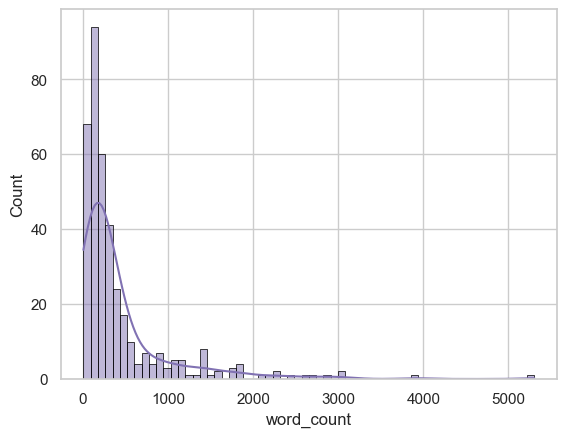

In [26]:
# Create histogram of text lengths for all texts
x = df_processed['word_count']
ax = sns.histplot(x, 
                   color='m', 
                   edgecolor='black', 
                   kde=True)  # kde=True for smooth distribution curve
plt.show()

#### Narrative vs praise

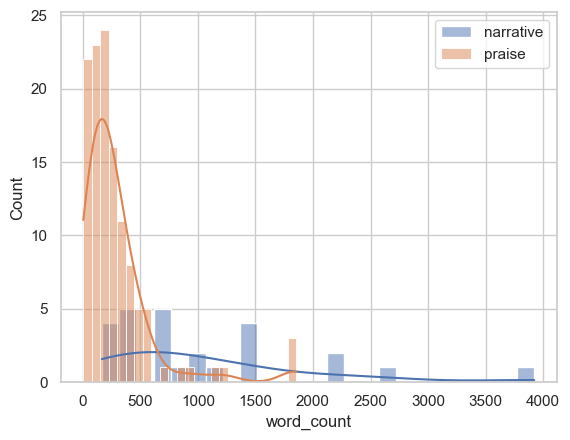

In [27]:
# Create histogram of word counts for narrative vs praise
df_processed['word_count']

# Filter df
narrative = df_processed.loc[df_processed['B_category']=='Narratives featuring deities']['word_count']
praise = df_processed.loc[df_processed['B_category']=='Royal praise poetry and hymns to deities on behalf of rulers']['word_count']

# Assign bin count and labels
sns.histplot(narrative, bins=25, kde=True, label='narrative')
sns.histplot(praise, bins=25, kde=True, label='praise')

plt.legend()
plt.show()

#### Inana vs Enlil

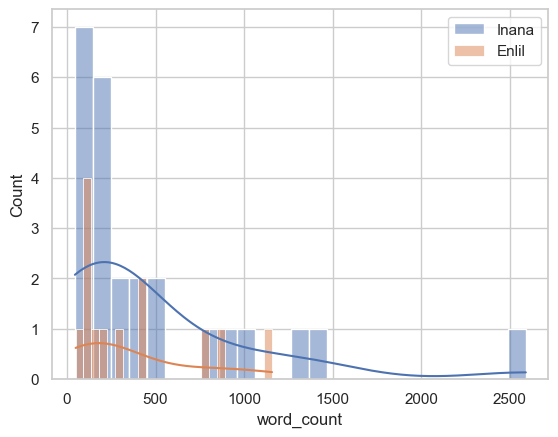

In [28]:
# Create histogram of word counts for Inana vs Enlil
df_processed['word_count']

# Create boolean masks that check each value in the column 'X; result: True or False
Inana = df_processed.loc[df_processed['God']=='Inana']['word_count'] # loc indexer accesses only 'True'
                                                                     # then selects 'word_count' column
Enlil = df_processed.loc[df_processed['God']=='Enlil']['word_count']

sns.histplot(Inana, bins=25, kde=True, label='Inana')
sns.histplot(Enlil, bins=25, kde=True, label='Enlil')

plt.legend()
plt.show()

#### Inana, Enlil, and Nana

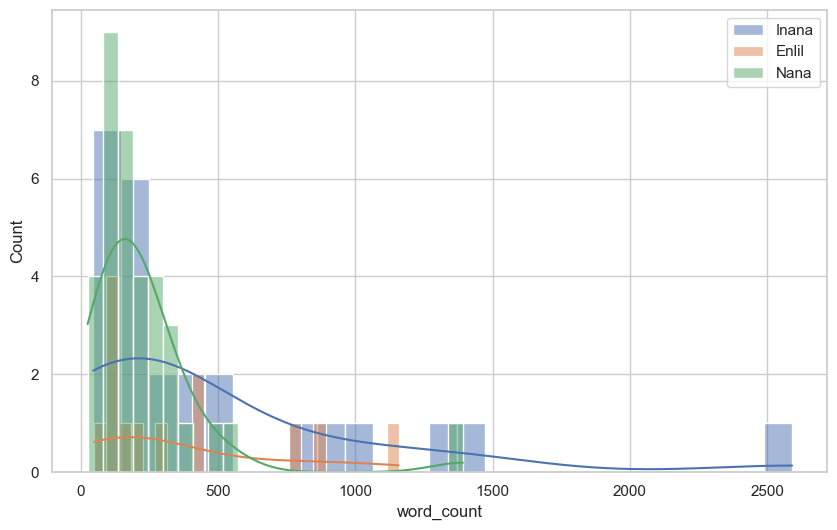

In [29]:
# Create histogram of word counts for Inana, Enlil, and Nana (all names)
plt.figure(figsize = (10, 6))
df_processed['word_count']

Inana = df_processed.loc[df_processed['God']=='Inana']['word_count']
Enlil = df_processed.loc[df_processed['God']=='Enlil']['word_count']
Nana = df_processed.loc[df_processed['God'].isin(['Nanna', 'Suen', 'Nanna-Suen'])]['word_count']

sns.histplot(Inana, bins=25, kde=True, label='Inana')
sns.histplot(Enlil, bins=25, kde=True, label='Enlil')
sns.histplot(Nana, bins=25, kde=True, label='Nana')

plt.legend()
plt.show()

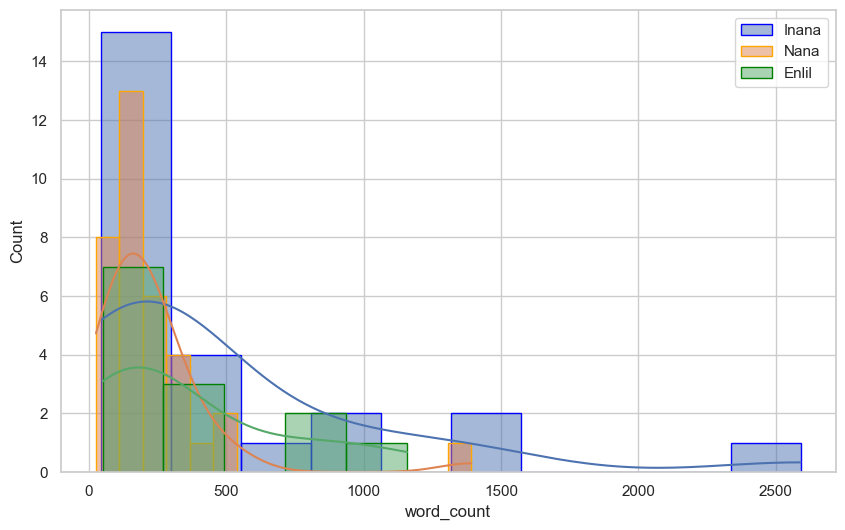

In [30]:
# Create histogram of word counts for Inana, Enlil, and Nana (all names) - no bins
plt.figure(figsize = (10, 6))
df_processed['word_count']

Inana = df_processed.loc[df_processed['God']=='Inana']['word_count']
Nana = df_processed.loc[df_processed['God'].isin(['Nanna', 'Suen', 'Nanna-Suen'])]['word_count']
Enlil = df_processed.loc[df_processed['God']=='Enlil']['word_count']

sns.histplot(Inana, kde=True, label='Inana', edgecolor='blue')
sns.histplot(Nana, kde=True, label='Nana', edgecolor='orange')
sns.histplot(Enlil, kde=True, label='Enlil', edgecolor='green')

plt.legend()
plt.show()

#### Gudea, Shulgi, Iddin-Dagen, & Rim-Suen

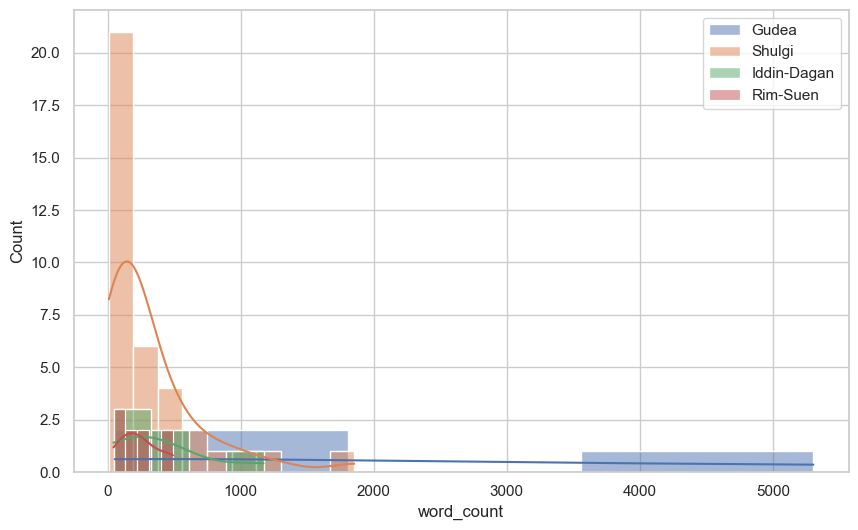

In [31]:
# Create histogram of word counts for persons Gudea, Shulgi, Iddin-Dagen, & Rim-Suen
plt.figure(figsize = (10, 6))
df_processed['word_count']

Gudea = df_processed.loc[df_processed['Person']=='Gudea']['word_count']
Shulgi = df_processed.loc[df_processed['Person']=='Shulgi']['word_count']
Iddin_Dagan = df_processed.loc[df_processed['Person']=='Iddin-Dagan']['word_count']
Rim_Suen = df_processed.loc[df_processed['Person']=='Rim-Suen']['word_count']

sns.histplot(Gudea, kde=True, label='Gudea')
sns.histplot(Shulgi, kde=True, label='Shulgi')
sns.histplot(Iddin_Dagan, kde=True, label='Iddin-Dagan')
sns.histplot(Rim_Suen, kde=True, label='Rim-Suen')

plt.legend()
plt.show()

# Get Word Counts, Frequencies, and Weights
**Count**\
The number of times a word occurs in a string

**Frequency**\
The percentage of times a word occurs; its relative occurrence compared to the total number of items in the string

**Weight**\
The importance of a term within a string or a set of strings\
Weights are calculated a few ways:
* Term Frequency (TF) similar to counting; the more often a term appears, the higher its term frequency weight
* Inverse Document Frequency (IDF) assesses how common or rare a term is across a set of documents
  * if a term appears in many documents, its IDF weight is low, therefore it's not considered very unique/important
  * if a term appears in few documents, its IDF weight is higher, suggesting it's more significant
* TF-IDF combines frequency and inverse document frequency
  * combined approach highlights terms that are frequent in a document but not common across all documents. This approach is best for text classification

## Get Most Common Words by Count per Text
Write function to tokenize and count lemmatized words
* tokenize `lemmatized` using .split() method for more control (rather than word_tokenize)
* count tokens using Counter
* return a dictionary
* pull out 5 most common words for each text

In [32]:
# Create function to count tokens & return a dictionary
def count_tokens(joined_string):
    lem_tokens = joined_string.split()
    
    # Create a Counter object
    token_counts = Counter(lem_tokens)
    
    # Get 5 most common tokens
    return token_counts.most_common(5)

In [33]:
# Apply 'count_tokens' and create new feature containing top token counts 'token_counts'
df_processed['token_counts'] = df_processed['lemmatized'].apply(count_tokens)
df_processed.head(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count,token_counts
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...,1440,"[(you, 51), (he, 45), (enki, 39), (month, 27),..."
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...,825,"[(not, 31), (enki, 27), (you, 22), (i, 22), (c..."


In [34]:
# Examine some tokens
print(f'These are the top 5 words in {df_processed.iloc[122, 4]}\n{df_processed.iloc[122, 8]}')

These are the top 5 words in A hymn to Inana for Ishme-Dagan
[('like', 4), ('son', 4), ('enlil', 4), ('sumer', 3), ('he', 3)]


In [35]:
# Examine A hymn to Inana for Ishme-Dagan in context of sentiment scores
print('Title:', df0.iloc[122, 9])
print('The agg_polarity score is', df0.iloc[122, 14].round(2), 'and the agg_subjectivity score is', df0.iloc[122, 15].round(2))
print('The whole_polarity score is', df0.iloc[122, 17].round(2), 'and the whole_subjectivity score is', df0.iloc[122, 18].round(2))
df0.iloc[122, 16]

Title: A hymn to Inana for Ishme-Dagan
The agg_polarity score is 0.02 and the agg_subjectivity score is 0.04
The whole_polarity score is 0.23 and the whole_subjectivity score is 0.35


"   …… squatting in the dust ……. …… of inana ……. …… of her garment of ladyship. …… with blood. …… her submission ……. …… insulted ……, cursed my temple. …… i despised him. …… cursed my city. …… devastated my ……. …… sullied my garments. …… rites ……. thus …… my mood and heart. as if during the night watch …… like excrement. …… my countenance like smoke. …… my body like blazing straw. …… kirugu. …… lady ……. its ĝišgiĝal. …… whose hands were fettered, …… who had been treated unjustly. the son of enlil, the son of ……. …… sumer ……. i, enlil, ……. from now on ……. he made the people follow the proper path, and ousted the enemy from sumer. he removed the wicked tongues, and made justice shine forth like copper. that fathers should be feared and mothers respected, that sons should pay heed to the words of their fathers, and that mercy, compassion and pity should be shown, that one should provide even one's paternal grandparents with food and drink; all this he established in sumer and akkad. then s

##### Note: these neutral terms align with the polarity and sentiment scores, but do not align with the *expected* more negative scores

### Group top words by genre
Create a function which counts the total number of words in the lemmatized text for each genre in `B_category` and stores counts in a dictionary

In [36]:
# Initialize empty dictionary to store counts for each genre
genre_counts = {}

# Iterate count through each genre group
for genre, group in df_processed.groupby('B_category'):  # group by genre, create subgroups
    combined_text = ' '.join(group['lemmatized'])  # join all text into single string
    genre_counts[genre] = count_tokens(combined_text) # call function count_tokens to join into a single string
                                                        # store in genre_counts, where genre is key

# Return dictionary
genre_counts

{'Animal fables': [('he', 32),
  ('i', 26),
  ('egg', 23),
  ('good', 20),
  ('enki', 19)],
 'City laments': [('city', 255),
  ('not', 168),
  ('he', 154),
  ('they', 152),
  ('you', 151)],
 'Debate poems': [('you', 241),
  ('i', 115),
  ('not', 111),
  ('he', 102),
  ('they', 71)],
 'Dialogues and diatribes': [('he', 26),
  ('not', 10),
  ('man', 9),
  ('engar-dug', 5),
  ('house', 5)],
 'Didactic compositions': [('you', 169),
  ('not', 116),
  ('son', 37),
  ('he', 33),
  ('let', 25)],
 'Hymns addressed to deities': [('you', 1063),
  ('he', 480),
  ('i', 476),
  ('great', 306),
  ('she', 265)],
 'Hymns addressed to or concerning temples': [('house', 279),
  ('great', 136),
  ('mountain', 56),
  ('heaven', 53),
  ('holy', 48)],
 'King lists and other compositions': [('he', 323),
  ('year', 241),
  ('ruled', 191),
  ('house', 135),
  ('king', 119)],
 'Lexical compositions': [('fish', 58),
  ('you', 57),
  ('enter', 28),
  ('may', 26),
  ('one', 21)],
 'Lu-digira compositions': [('you',

### Group top words by god

In [37]:
god_counts = {}

for god, group in df_processed.groupby('God'):
    combined_text = ' '.join(group['lemmatized'])
    god_counts[god] = count_tokens(combined_text)

god_counts

{'An': [('you', 48), ('may', 36), ('anu', 34), ('great', 21), ('he', 19)],
 'Asarluhi': [('you', 13), ('god', 9), ('they', 8), ('great', 8), ('name', 7)],
 'Bau': [('you', 106),
  ('bau', 45),
  ('great', 43),
  ('mountain', 35),
  ('lady', 34)],
 'Dagan': [('išme-dagan', 4),
  ('divine', 4),
  ('power', 4),
  ('dagan', 3),
  ('e-kur', 2)],
 'Damgalnuna': [('great', 5),
  ('enki', 3),
  ('lord', 3),
  ('prince', 2),
  ('you', 2)],
 'Enki': [('you', 179), ('enki', 166), ('he', 161), ('i', 102), ('lord', 79)],
 'Enlil': [('enlil', 157),
  ('you', 145),
  ('he', 114),
  ('great', 68),
  ('lord', 63)],
 'Gods': [('he', 1119), ('you', 604), ('like', 544), ('not', 532), ('i', 530)],
 'Haia': [('great', 13), ('you', 13), ('god', 12), ('ḫaia', 9), ('holy', 9)],
 'Hendursaga': [('he', 45),
  ('you', 28),
  ('not', 19),
  ('stand', 18),
  ('ḫendursaĝa', 16)],
 'Inana': [('you', 666),
  ('inana', 293),
  ('i', 277),
  ('he', 215),
  ('she', 185)],
 'Inana and Dumuzid': [('you', 348),
  ('i', 278)

### Group top words by person

In [38]:
person_counts = {}
for person, group in df_processed.groupby('Person'):
    combined_text = ' '.join(group['lemmatized'])
    person_counts[person] = count_tokens(combined_text)

person_counts

{'Aba-tah-lugalga': [('journey', 5),
  ('one', 3),
  ('say', 2),
  ('long', 2),
  ('king', 2)],
 'Abi-Eshuh': [('heaven', 8), ('earth', 7), ('god', 7), ('he', 7), ('you', 7)],
 'Amar-Suena': [('he', 16),
  ('temple', 16),
  ('not', 16),
  ('amar-suena', 10),
  ('year', 9)],
 'Anam': [('you', 7), ('great', 4), ('nibru', 3), ('inana', 3), ('e-ana', 3)],
 'Bilulu': [('lament', 37),
  ('you', 32),
  ('desert', 24),
  ('let', 19),
  ('she', 17)],
 'Bur-Suen': [('you', 11),
  ('may', 9),
  ('ninurta', 7),
  ('land', 7),
  ('great', 6)],
 'Enkimdu': [('i', 27),
  ('farmer', 26),
  ('let', 19),
  ('you', 19),
  ('shepherd', 18)],
 'Enlil-bani': [('you', 38),
  ('enlil', 12),
  ('land', 9),
  ('bāni', 6),
  ('king', 5)],
 'Enmerkar': [('he', 171),
  ('aratta', 105),
  ('like', 95),
  ('lord', 95),
  ('i', 79)],
 'Geshtinana': [('they', 22),
  ('demon', 14),
  ('lad', 12),
  ('she', 12),
  ('brother', 11)],
 'Gilgamesh': [('he', 340),
  ('you', 291),
  ('not', 164),
  ('i', 156),
  ('gilgameš', 

##### Note: Iddin-Dagan has Inana (and "lady") in top 5, Ishme_dagan has Enlil and "I", Lipit-Eshtar has Enlil, "I" and "you"

## Visual: Create a simple frequency chart for top words for all texts
* A simple frequency object plots the absolute counts of each token in the selected feature
* For a relative frequencies (the proportion of each token relative to the total number of tokens), each count must be divided by the total number of tokens


*This is a simple count chart*

In [39]:
# Split 'lemmatized' into tokens to prepare texts
df_processed['split_tokens'] = df_processed['lemmatized'].str.split()
df_processed.head(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count,token_counts,split_tokens
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...,1440,"[(you, 51), (he, 45), (enki, 39), (month, 27),...","[pure, city, you, one, they, allotted, pure, d..."
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...,825,"[(not, 31), (enki, 27), (you, 22), (i, 22), (c...","[day, day, heaven, earth, created, night, nigh..."


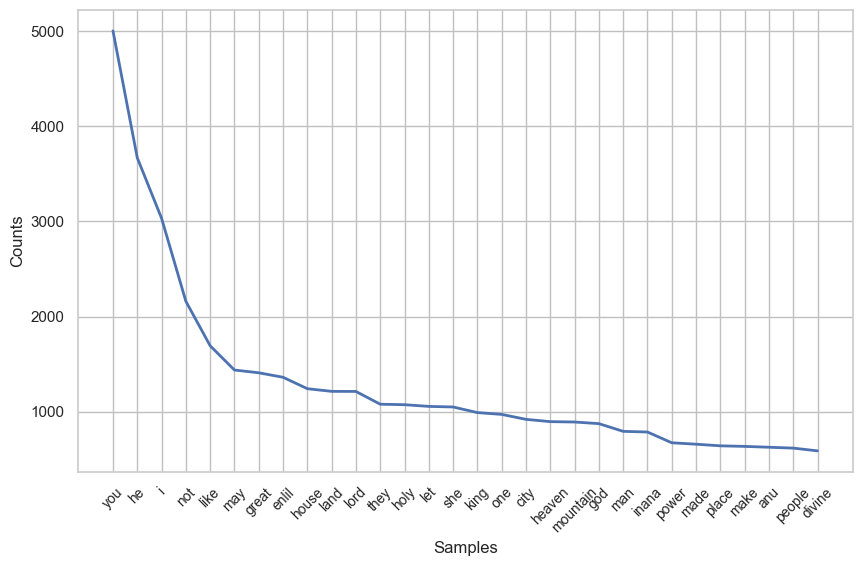

In [40]:
# Make a frequency chart
from itertools import chain

# Flatten the list of lists
all_tokens = list(chain.from_iterable(df_processed['split_tokens']))

# Create frequency distribution
freqdist1 = nltk.FreqDist(all_tokens)

# Plot the frequency distribution
plt.figure(figsize = (10, 6))
freqdist1.plot(30) # select top 30
plt.xticks(rotation = 45, fontsize = 10); # rotate x-axis labels and decrease font size

In [41]:
# Get 200 most common tokens for all texts
token_counts = Counter(all_tokens)
print(token_counts.most_common(200))

[('you', 5001), ('he', 3668), ('i', 3033), ('not', 2161), ('like', 1694), ('may', 1439), ('great', 1410), ('enlil', 1363), ('house', 1243), ('land', 1215), ('lord', 1214), ('they', 1080), ('holy', 1075), ('let', 1057), ('she', 1051), ('king', 992), ('one', 973), ('city', 921), ('heaven', 897), ('mountain', 893), ('god', 876), ('man', 795), ('inana', 788), ('power', 675), ('made', 660), ('place', 643), ('make', 637), ('anu', 628), ('people', 619), ('divine', 590), ('good', 577), ('shall', 575), ('heart', 573), ('water', 567), ('hand', 559), ('son', 559), ('day', 538), ('lady', 536), ('earth', 527), ('mother', 505), ('father', 500), ('enki', 474), ('whose', 463), ('word', 450), ('brought', 415), ('come', 403), ('name', 402), ('shepherd', 396), ('go', 395), ('utu', 379), ('head', 358), ('life', 357), ('year', 348), ('bull', 343), ('set', 323), ('upon', 320), ('bird', 317), ('say', 317), ('woman', 314), ('ninurta', 308), ('give', 297), ('hero', 294), ('away', 289), ('said', 288), ('know', 

##### Note: for all tokens, you(4448) beats out I(3033). Enlil(1201) has almost twice as many counts as Inana (650). Mother(483) leads slightly over father (475). Other gods: Enki, 374, Utu, 334, Ninurta, 215, Nana, 209, Suen, 181, the Anunaki, 178, Ninlil, 172; Uurk, 180 slightly more than Nippur, 157

In [42]:
df_processed.drop(columns=['split_tokens'], inplace=True)
df_processed.columns

Index(['B_category', 'God', 'Number', 'Person', 'Title', 'joined_text',
       'lemmatized', 'word_count', 'token_counts'],
      dtype='object')

In [43]:
# Save to csv
df_processed.to_csv('all_texts_processed.csv', index=False)
df = pd.read_csv('all_texts_processed.csv')
df.head(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count,token_counts
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...,1440,"[('you', 51), ('he', 45), ('enki', 39), ('mont..."
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...,825,"[('not', 31), ('enki', 27), ('you', 22), ('i',..."


In [44]:
df.columns

Index(['B_category', 'God', 'Number', 'Person', 'Title', 'joined_text',
       'lemmatized', 'word_count', 'token_counts'],
      dtype='object')

## Weights
**Get bi-grams with tfidf_vectorizer**
* Create custom bi-gram tokenizer function to remove repeated words, since punctuation will be removed
* Initialize tfidf_vectorizer
* Create function to get top word (n-grams) and their weights
  
**Get tri-grams with tfidf_vectorizer**
* Create custom tokenizer to keep hyphenated words together

In [45]:
# Check that lemmatized class is string
sample_types = df['lemmatized'].head().apply(type)
print(sample_types)

0    <class 'str'>
1    <class 'str'>
2    <class 'str'>
3    <class 'str'>
4    <class 'str'>
Name: lemmatized, dtype: object


In [46]:
# Check for recent/changes to arguments
# TfidfVectorizer?

#### Create custom tokenizer function for bi-grams 
Function will split text into tokens and create filtered bi-grams (pairs of consecutive words that aren't repeated)
* Split text into tokens separated by a space using .split() method
* Create bi-grams using a list comprehension that iterates through the indices of the tokens list to create a bi-gram for each pair of words
> bi_grams = [f'{tokens[i]} {tokens[i+1]}' for i in range(len(tokens)-1)]
> * range(len(tokens)-1) gives total number of tokens (words) in list and generates a sequence of indices from 0 to len(tokens)-1
>   * subtracting 1 ensures that when tokens[i+1] are accessed, they don't go out of bounds of the list
> * expression f'{tokens[i]} {tokens[i+1]}' uses an f-string (formatted string literal) to concatenate the current token and the next token with a space in between, thereby forming a bi-gram
* Compare and filter out repeated words

In [47]:
# Create customized tokenizer for unique bi-grams to filter out repeating words
# List comprehension collects all bi-grams into a new list called bi_grams
def custom_tokenizer(text):
    # Split text into tokens
    tokens = text.split()
    
    # Create bi-grams and filter out repeated words
    bi_grams = [f'{tokens[i]} {tokens[i+1]}' for i in range(len(tokens)-1)] # tokens[i] refers to the current token at index i
                                                                            # tokens[i+1] refers to the next token in the list
    
    # Filter out bi-grams with repeated words through comparison
    bi_grams = [bg for bg in bi_grams if bg.split()[0] != bg.split()[1]] 

    # Create debugging line
    # print('Generated bi-grams:', bi_grams)

    # Check that no token is longer than 2 words
    # for bg in bi_grams:
        # if len(bg.split()) > 2:
            # print(f"Warning: Token exceeds 2 words - '{bg}'")
    
    # Return only bi-grams
    return bi_grams

#### Initialize a Tf-idf vectorizer

In [48]:
# Initialize a Tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,
                                   analyzer='word',  # analyze on word level
                                   stop_words=None,  # no stopwords will be removed
                                   preprocessor=None, # no preprocessing, as would override tailored processing
                                   max_features=1000, # max n-grams is 1000
                                   max_df=0.8, # exclude words that occur in more than 80% of docs (texts)
                                   ngram_range=(1, 1) # n-gram range is 1 because custom tokenizer creates bi-grams which are considered 1
                                  )

# Fit and transform corpus
Xtfidf = tfidf_vectorizer.fit_transform(df['lemmatized'])

/Users/ilona/mynumpyenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Get vocabulary: Create dictionary grouping bi-grams by first letter

In [49]:
# Create a dictionary to group words by their first letter
vocabulary = tfidf_vectorizer.get_feature_names_out()
grouped_vocab = {}

for word in vocabulary:     # iterate over each document
    first_letter = word[0] 
    if first_letter not in grouped_vocab:
        grouped_vocab[first_letter] = []
    grouped_vocab[first_letter].append(word)

# Display grouped vocabulary
for letter, words in sorted(grouped_vocab.items()):
    print(f'{letter}: {words}')

a: ['abandoned let', 'abzu eridug', 'abzu he', 'abzu i', 'abzu shrine', 'acted year', 'ala destroyed', 'ala drum', 'also enter', 'among anuna', 'among god', 'among great', 'among people', 'animal pen', 'another one', 'anu adab', 'anu enlil', 'anu he', 'anu king', 'anu not', 'anu you', 'anuna god', 'anuna great', 'anyone else', 'anzud bird', 'arable tract', 'aratta he', 'aromatic cedar', 'awaits you', 'away like', 'away you']
b: ['balaĝ drum', 'balbale inana', 'battle i', 'bau you', 'became king', 'beloved anu', 'beloved son', 'bestowed you', 'bitter lament', 'bitter tear', 'black-headed people', 'boat heaven', 'breeze haunt', 'brick building', 'brick mould', 'brick-built kulaba', 'bright mountain', 'bring forth', 'bring you', 'brings forth', 'broad wisdom', 'brother friend', 'brother let', 'brother you', 'brought forth', 'brought house', 'brought you', 'build house', 'building house', 'bull heaven', 'bull mountain', 'butter milk']
c: ['call upon', 'called name', 'came forth', 'carried 

#### Get top bi-grams
* Create function `get_top_tfidf_words_per_doc` to get top word (bi-gram, later tri-gram) for each doc and its weight
  * add placeholder option for docs with no significant terms 
* Print all unique top bi-grams
* Get duplicated top bi-grams for all texts and their total counts

In [50]:
# Convert doc-term matrix into a dense format to have fewer zero values
Xtfidf_dense = Xtfidf.toarray()

In [51]:
# Get top n-grams and frequency
# Create place holder for zero values
def get_top_tfidf_words_per_doc(matrix, vectorizer):
    
    # Initialize a list to store top words and their frequencies
    top_tfidf_words_per_doc = []
    
    for i in range(matrix.shape[0]):  # iterate over each document
        sorted_indices = np.argsort(matrix[i])[::-1]  # sort indices by frequency
        
        if matrix[i][sorted_indices[0]] > 0:  # check that highest score is > than zero
            top_tfidf_words = [(vectorizer.get_feature_names_out()[index], matrix[i][index]) for index in sorted_indices[:1]]
        
        else:
            top_tfidf_words = [('No significant terms', 0)]  # placeholder for docs with no significant terms
            
        # Append the top word and its weight to list
        for word, weight in top_tfidf_words:
            top_tfidf_words_per_doc.append({'tfidf_index': i, 'tfidf_top_word': word, 'tfidf_weight': weight})
                
    # Create a df from the list
    top_tfidf_words_per_doc = pd.DataFrame(top_tfidf_words_per_doc)
    
    return top_tfidf_words_per_doc

In [52]:
# Get top bi-grams for all documents
top_tfidf_bigrams = get_top_tfidf_words_per_doc(Xtfidf_dense, tfidf_vectorizer)
top_tfidf_bigrams

,tfidf_index,tfidf_top_word,tfidf_weight
0,0,oil like,0.456462
1,1,could not,0.632673
2,2,placed charge,0.441271
3,3,lapis lazuli,0.359915
4,4,enlil lord,0.296460
...,...,...,...
376,376,he not,0.485982
377,377,pay attention,0.711468
378,378,slave girl,0.365659
379,379,he man,0.741716


In [53]:
# Get texts with no significant bi-grams
no_sig = top_tfidf_bigrams.loc[top_tfidf_bigrams['tfidf_weight'] == 0.0]
no_sig

,tfidf_index,tfidf_top_word,tfidf_weight
87,87,No significant terms,0.0
186,186,No significant terms,0.0
279,279,No significant terms,0.0
347,347,No significant terms,0.0


### Examine some bi-grams

In [54]:
# Check out no-sig 186
print(
    f'The top weighted bi-gram and weight for: {df_processed.iloc[186, 4]}\n{top_tfidf_bigrams.iloc[186, 1]}\n{top_tfidf_bigrams.iloc[186, 2]}'
     )
print('Text:', df_processed.iloc[186, 5])

The top weighted bi-gram and weight for: Letter from Shulgi (?) to Aradgu about troops
No significant terms
0.0
Text:  to aradĝu …… …… šulgi ……    as regards your concern ……. may ……. for their troops …… not ……. their troops …….


In [55]:
# Check out significant 379
print(
    f'The top weighted bi-gram and weight for: {df_processed.iloc[379, 4]}\n{top_tfidf_bigrams.iloc[379, 1]}\n{top_tfidf_bigrams.iloc[379, 2]}'
     )
print('Text:', df_processed.iloc[379, 5])

The top weighted bi-gram and weight for: Proverbs: from Unug
he man
0.7417159280682647
Text: ...,...,.. he holds up the sky, letting the earth dangle from his hands. ... enlil's greatest punishment is hunger. ... he bears the responsibility for it. ... when he …… the man's assassin, he became his opponent. ... as a provisioner, …… upon those who speak proudly. ... the …… wind …… harmful. the east wind is a rain-bearing wind; the west wind is greater than those who live there. the east wind is a wind of prosperity, the friend of naram-suen. …… poured it out for him ……. …… gave birth …… like a nindiĝir priestess, the young girl …… coming out, the young girl …… returned it …….


In [56]:
# Examine text in context of sentiment scores
print('Title:', df0.iloc[122, 9])
print('The agg_polarity score is', df0.iloc[122, 14].round(2), 'and the agg_subjectivity score is', df0.iloc[122, 15].round(2))
print('The whole_polarity score is', df0.iloc[122, 17].round(2), 'and the whole_subjectivity score is', df0.iloc[122, 18].round(2))
print('Most numerous words are:', df_processed.iloc[122, 8])
print('The top weighted bi-gram and weight are:', top_tfidf_bigrams.iloc[122, 1], 'and', top_tfidf_bigrams.iloc[122, 2])
df0.iloc[122, 16]

Title: A hymn to Inana for Ishme-Dagan
The agg_polarity score is 0.02 and the agg_subjectivity score is 0.04
The whole_polarity score is 0.23 and the whole_subjectivity score is 0.35
Most numerous words are: [('like', 4), ('son', 4), ('enlil', 4), ('sumer', 3), ('he', 3)]
The top weighted bi-gram and weight are: son enlil and 0.3409637598134083


"   …… squatting in the dust ……. …… of inana ……. …… of her garment of ladyship. …… with blood. …… her submission ……. …… insulted ……, cursed my temple. …… i despised him. …… cursed my city. …… devastated my ……. …… sullied my garments. …… rites ……. thus …… my mood and heart. as if during the night watch …… like excrement. …… my countenance like smoke. …… my body like blazing straw. …… kirugu. …… lady ……. its ĝišgiĝal. …… whose hands were fettered, …… who had been treated unjustly. the son of enlil, the son of ……. …… sumer ……. i, enlil, ……. from now on ……. he made the people follow the proper path, and ousted the enemy from sumer. he removed the wicked tongues, and made justice shine forth like copper. that fathers should be feared and mothers respected, that sons should pay heed to the words of their fathers, and that mercy, compassion and pity should be shown, that one should provide even one's paternal grandparents with food and drink; all this he established in sumer and akkad. then s

#### Get all unique bi-grams

In [57]:
# Print all unique top bi-grams
print('There are', top_tfidf_bigrams['tfidf_top_word'].nunique(), 'top bi-grams:')
print(sorted(top_tfidf_bigrams['tfidf_top_word'].unique()))

There are 281 top bi-grams:
['No significant terms', 'abzu shrine', 'acted year', 'ala destroyed', 'among god', 'among people', 'animal pen', 'another one', 'anu enlil', 'anu you', 'anuna god', 'arable tract', 'aromatic cedar', 'balbale inana', 'bau you', 'brick building', 'bright mountain', 'broad wisdom', 'brought you', 'bull mountain', 'call upon', 'city whose', 'come forth', 'come let', 'coming forth', 'compete you', 'could not', 'cover land', 'cultied field', 'day he', 'day may', 'day night', 'destroyed city', 'determined fate', 'dig canal', 'distant future', 'divine power', 'drink he', 'e-kur house', 'earth i', 'en priesthood', 'enlil enki', 'enlil heart', 'enlil i', 'enlil look', 'enlil lord', 'enlil ninlil', 'enlil son', 'enlil temple', 'enter you', 'father enki', 'father holy', 'father mother', 'fattened sheep', 'first-born son', 'fish bird', 'foreign country', 'foreign land', 'founded anu', 'gave birth', 'gaze upon', 'gilgameš lord', 'give birth', 'gone around', 'good woman',

#### Check out duplicates

In [58]:
# Get duplicated top bi-grams for all texts in top_tfidf_words_df and their total counts
# Get duplicates
duplicates = top_tfidf_bigrams.loc[top_tfidf_bigrams['tfidf_top_word'].duplicated(keep=False)].copy()

# Add the 'is_duplicate' column using .loc
duplicates.loc[:, 'is_duplicate'] = duplicates['tfidf_top_word'].duplicated(keep=False)

# Sort duplicates
duplicates_sort = duplicates.sort_values(by=['tfidf_top_word', 'is_duplicate'], ascending=[True, False])

# Get value counts of 'tfidf_top_word'
duplicates_sort_value = duplicates_sort['tfidf_top_word'].value_counts()

In [59]:
# Show top duplicates
duplicates_sort_value.head(10)

tfidf_top_word
may he                  13
divine power            10
may you                  9
slave girl               8
No significant terms     4
say lord                 4
determined fate          4
holy ninisina            3
you not                  3
you may                  3
Name: count, dtype: int64

In [60]:
# Get counts and percentages for duplicate bi-grams
counts = top_tfidf_bigrams['tfidf_top_word'].value_counts()
percentages = top_tfidf_bigrams['tfidf_top_word'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

result= pd.DataFrame({'count': counts, 'percentage': percentages}).reset_index()

# Get only those bi-grams than appear more than once
more_than_1 = result.loc[result['count'] >= 2]
more_than_1.style.background_gradient()

,tfidf_top_word,count,percentage
0,may he,13,3.4%
1,divine power,10,2.6%
2,may you,9,2.4%
3,slave girl,8,2.1%
4,No significant terms,4,1.0%
5,determined fate,4,1.0%
6,say lord,4,1.0%
7,i šulgi,3,0.8%
8,enlil look,3,0.8%
9,holy inana,3,0.8%


##### Note: the pronoun 'us' is still showing up a u. This is likely because pronouns were kept and 's' was then removed from 'us' 

### Create top bi-grams dictionary by `B_category`, `God`, and `Person`
* Lists will include the top bi-gram for each text within the genre and the number of texts in which they appear as top bi-grams
* Create `count_tokens` function

In [61]:
# Created merged df 'top_word_df'
top_word_df = pd.merge(df_processed, top_tfidf_bigrams, left_index=True, right_index=True)
top_word_df.head(2).round(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count,token_counts,tfidf_index,tfidf_top_word,tfidf_weight
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...,1440,"[(you, 51), (he, 45), (enki, 39), (month, 27),...",0,oil like,0.46
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...,825,"[(not, 31), (enki, 27), (you, 22), (i, 22), (c...",1,could not,0.63


In [62]:
top_word_df.columns

Index(['B_category', 'God', 'Number', 'Person', 'Title', 'joined_text',
       'lemmatized', 'word_count', 'token_counts', 'tfidf_index',
       'tfidf_top_word', 'tfidf_weight'],
      dtype='object')

In [63]:
# Drop `tfidf_index` column
top_word_df.drop(['tfidf_index'], axis=1,inplace=True)
top_word_df.head(2).round(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count,token_counts,tfidf_top_word,tfidf_weight
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...,1440,"[(you, 51), (he, 45), (enki, 39), (month, 27),...",oil like,0.46
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...,825,"[(not, 31), (enki, 27), (you, 22), (i, 22), (c...",could not,0.63


In [64]:
# Save ‘top_word_df’ to a CSV 
top_word_df.to_csv('top_word_df.csv', index=False)
top_word_df = pd.read_csv('top_word_df.csv')
top_word_df.head(2).round(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count,token_counts,tfidf_top_word,tfidf_weight
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...,1440,"[('you', 51), ('he', 45), ('enki', 39), ('mont...",oil like,0.46
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...,825,"[('not', 31), ('enki', 27), ('you', 22), ('i',...",could not,0.63


In [65]:
pd.set_option('display.max_colwidth', None)

# Write function to count tokens and sort the results
def count_tokens(word_list):
    counts = Counter(word_list)

    # Sort the items based on the counts
    sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))  # items() = displays list of dict's tuple pairs ((key, value))
                                                                                    # item[1] accesses 2nd element to count
    return sorted_counts

#### By Genre

In [66]:
# Group top bi-grams by genre
merged_genre = top_word_df.groupby('B_category')['tfidf_top_word'].apply(list).reset_index()

# Create a dictionary of bi-grams for each genre
merged_genre['tfidf_top_word'] = merged_genre['tfidf_top_word'].apply(count_tokens)
merged_genre

,B_category,tfidf_top_word
0,Animal fables,{'laid egg': 1}
1,City laments,"{'haunt sheepfold': 1, 'ala destroyed': 1, 'brick building': 1, 'they shall': 1, 'destroyed city': 1}"
2,Debate poems,"{'you not': 2, 'holy mound': 1, 'arable tract': 1, 'strong copper': 1, 'he ressed': 1}"
3,Dialogues and diatribes,"{'open house': 1, 'man he': 1}"
4,Didactic compositions,"{'you not': 1, 'not let': 1}"
5,Hymns addressed to deities,"{'divine power': 3, 'may you': 3, 'one you': 2, 'put order': 2, 'lord ninĝišzida': 2, 'holy ninisina': 2, 'power heaven': 1, 'protective goddess': 1, 'great prince': 1, 'would not': 1, 'stand behest': 1, 'may great': 1, 'great anu': 1, 'compete you': 1, 'utu he': 1, 'he gave': 1, 'i go': 1, 'you come': 1, 'imbued awesomeness': 1, 'you she': 1, 'you already': 1, 'shall take': 1, 'let bring': 1, 'let go': 1, 'tree he': 1, 'meš tree': 1, 'you brother': 1, 'mother ningal': 1, 'šuba jewel': 1, 'en priesthood': 1, 'good woman': 1, 'i place': 1, 'learn way': 1, 'she chooses': 1, 'like daylight': 1, 'may sheep': 1, 'let u': 1, 'i going': 1, 'he like': 1, 'she desire': 1, 'balbale inana': 1, 'he laid': 1, 'milk let': 1, 'inana may': 1, 'he make': 1, 'oil cedar': 1, 'he poured': 1, 'i shall': 1, 'purification rite': 1, 'fish bird': 1, 'you he': 1, 'day night': 1, 'nanna lord': 1, 'founded anu': 1, 'tended cow': 1, 'youthful suen': 1, 'heaven earth': 1, 'may he': 1, 'upon dais': 1, 'come forth': 1, 'first-born son': 1, 'mountain enlil': 1, 'among god': 1, 'No significant terms': 1, 'city whose': 1, 'like ox': 1, 'mother nanše': 1, 'land you': 1, 'may people': 1, 'take seat': 1, 'distant future': 1, 'anuna god': 1, 'lady you': 1, 'aromatic cedar': 1, 'house she': 1, 'father holy': 1, 'determined fate': 1, 'mother ninlil': 1, 'heart i': 1, 'you said': 1, 'mother nintur': 1, 'he come': 1, 'ninurta great': 1, 'strength enlil': 1, 'give birth': 1, 'hero ninurta': 1, 'ninurta son': 1, 'shine forth': 1, 'man not': 1, 'power you': 1, 'let you': 1, 'he lifted': 1, 'gaze upon': 1, 'utu you': 1, 'enlil heart': 1, 'coming forth': 1}"
6,Hymns addressed to or concerning temples,"{'house precinct': 1, 'lady nintur': 1, 'great mountain': 1}"
7,King lists and other compositions,"{'ruled year': 1, 'acted year': 1, 'enlil temple': 1, 'holy inana': 1, 'took away': 1, 'mighty man': 1, 'lord ninĝirsu': 1}"
8,Lexical compositions,{'enter you': 1}
9,Lu-digira compositions,"{'let give': 1, 'you may': 1, 'call upon': 1}"


#### By God

In [67]:
# Group top bi-grams by god
merged_god = top_word_df.groupby('God')['tfidf_top_word'].apply(list).reset_index()

# Create a dictionary of bi-grams for each god
merged_god['tfidf_top_word'] = merged_god['tfidf_top_word'].apply(count_tokens)
merged_god

,God,tfidf_top_word
0,An,"{'may you': 2, 'determined fate': 1, 'may he': 1}"
1,Asarluhi,"{'great god': 1, 'power heaven': 1}"
2,Bau,"{'anu you': 1, 'bau you': 1, 'gave birth': 1, 'mother bau': 1, 'protective goddess': 1, 'great mountain': 1}"
3,Dagan,{'išme-dagan son': 1}
4,Damgalnuna,{'great prince': 1}
5,Enki,"{'divine power': 2, 'oil like': 1, 'could not': 1, 'placed charge': 1, 'lapis lazuli': 1, 'he not': 1, 'father enki': 1, 'holy anu': 1, 'king enki': 1, 'may he': 1}"
6,Enlil,"{'enlil lord': 1, 'people you': 1, 'shepherd ur-namma': 1, 'cultied field': 1, 'something great': 1, 'anuna god': 1, 'lapis lazuli': 1, 'i make': 1, 'may he': 1, 'samsu iluna': 1, 'e-kur house': 1, 'would not': 1, 'you may': 1}"
7,Gods,"{'anu enlil': 1, 'gilgameš lord': 1, 'man battle': 1, 'never rise': 1, 'you see': 1, 'mountain cave': 1, 'holy lugalbanda': 1, 'lord aratta': 1, 'animal pen': 1, 'ruled year': 1, 'acted year': 1, 'enlil temple': 1, 'holy inana': 1, 'took away': 1, 'mighty man': 1, 'lord ninĝirsu': 1, 'haunt sheepfold': 1, 'ala destroyed': 1, 'brick building': 1, 'they shall': 1, 'destroyed city': 1, 'nether world': 1, 'enlil i': 1, 'house precinct': 1}"
8,Haia,{'abzu shrine': 1}
9,Hendursaga,{'stand behest': 1}


#### By Person

In [68]:
# Group top bi-grams by person
merged_person = top_word_df.groupby('Person')['tfidf_top_word'].apply(list).reset_index()

# Create a dictionary of bi-grams for each person
merged_person['tfidf_top_word'] = merged_person['tfidf_top_word'].apply(count_tokens)
merged_person

,Person,tfidf_top_word
0,Aba-tah-lugalga,{'not able': 1}
1,Abi-Eshuh,"{'heaven earth': 1, 'day may': 1}"
2,Amar-Suena,{'he not': 1}
3,Anam,{'great destiny': 1}
4,Bilulu,{'you lament': 1}
5,Bur-Suen,"{'may he': 1, 'i make': 1}"
6,Enkimdu,{'milk let': 1}
7,Enlil-bani,{'you enlil': 1}
8,Enmerkar,"{'lord aratta': 1, 'animal pen': 1}"
9,Geshtinana,{'come let': 1}


### Get tri-grams with tfidf_vectorizer
* Since no tailored tokenizer, create empty function to keep hyphenated words
> def keep_hyphens(text):\
> return text
  * did not work
* Create regex tokenizer to keep hyphens

In [69]:
# Custom tokenizer to avoid break-up of hyphenated words
def custom_tokenizer(text):
    
    # Use regex findall to find/keep hyphenated words together as single tokens
    return re.findall(r'\b\w+(?:-\w+)?\b', text)

In [70]:
# Initialize TfidfVectorizer with the custom tokenizer
tfidf_vectorizer3 = TfidfVectorizer(
    tokenizer=custom_tokenizer,  # use the custom tokenizer to keep hyphenated words
    stop_words=None,  # no stopwords will be removed
    max_df=0.8,  # exclude words that occur in more than 80% of docs
    max_features=1000,  # max n-grams is 1000
    ngram_range=(3, 3)  # n-gram range is tri
)

# Fit and transform the corpus
Xtfidf3 = tfidf_vectorizer3.fit_transform(df['lemmatized'])

/Users/ilona/mynumpyenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Get vocabulary: Create dictionary grouping words by first letter

In [71]:
# Create a dictionary to group tri-grams by their first letter
vocabulary3 = tfidf_vectorizer3.get_feature_names_out()
grouped_vocab = {}

for word in vocabulary3:
    first_letter = word[0] 
    if first_letter not in grouped_vocab:
        grouped_vocab[first_letter] = []
    grouped_vocab[first_letter].append(word)

# Display grouped vocabulary
for letter, words in sorted(grouped_vocab.items()):
    print(f'{letter}: {words}')

a: ['abandoned let breeze', 'able see he', 'abzu he duplicitously', 'abzu i give', 'according heavenly star', 'acknowledge fame i', 'adressed minister ninšubur', 'air full bird', 'ala destroyed city', 'alive longer alive', 'alloyed dirt underworld', 'along bank surungal', 'along dark path', 'along road together', 'also enter you', 'altered promise far', 'among anuna god', 'among great god', 'among great prince', 'among numerous people', 'animal pen byre', 'another one detail', 'answered holy inana', 'anu enlil enki', 'anu enlil not', 'anu enlil you', 'anu king god', 'anu not change', 'anu you brought', 'anuna god i', 'anuna god stand', 'anuna great god', 'anyone else bring', 'anyone great lady', 'anyone kill daughter', 'appropriately acknowledge fame', 'around heaven she', 'august divine power', 'away you brother', 'ašgi ever seen', 'ašimbabbar despatched people']
b: ['back eridug holy', 'bank surungal canal', 'battle i sing', 'became king he', 'become kinsman ḫuwawa', 'bed i lie', 'be

#### Get top tri-grams
* Use function `get_top_tfidf_words_per_doc`
* Print all unique top tri-grams
* Get duplicated top tri-grams for all texts and their total counts

In [72]:
# Get top tri-grams for all documents and store in a df using function 'get_top_tfidf_words_per_doc'
Xtfidf_dense3 = Xtfidf3.toarray()

top_tfidf_trigrams = get_top_tfidf_words_per_doc(Xtfidf_dense3, tfidf_vectorizer3)
top_tfidf_trigrams

,tfidf_index,tfidf_top_word,tfidf_weight
0,0,fine oil like,0.399304
1,1,i decreed fate,0.576931
2,2,enki placed charge,0.680821
3,3,lord determines fate,0.613654
4,4,not talked loveliest,0.390583
...,...,...,...
376,376,No significant terms,0.000000
377,377,let tell you,1.000000
378,378,bread left stranger,0.492264
379,379,No significant terms,0.000000


#### Examine some tri-grams

In [73]:
print(
    f'The top weighted tri-gram and weight for: {df_processed.iloc[378, 4]}\n{top_tfidf_trigrams.iloc[378, 1]}\n{top_tfidf_trigrams.iloc[378, 2]}'
     )

The top weighted tri-gram and weight for: Proverbs: from Urim
bread left stranger
0.49226375607803025


In [74]:
print(
    f'The top weighted tri-gram and weight for: {df_processed.iloc[376, 4]}\n{top_tfidf_trigrams.iloc[376, 1]}\n{top_tfidf_trigrams.iloc[376, 2]}'
     )

The top weighted tri-gram and weight for: Proverbs: from Nibru
No significant terms
0.0


In [75]:
# Examine text in context of sentiment scores
print('Title:', df0.iloc[122, 9])
print('The agg_polarity score is', df0.iloc[122, 14].round(2), 'and the agg_subjectivity score is', df0.iloc[122, 15].round(2))
print('The whole_polarity score is', df0.iloc[122, 17].round(2), 'and the whole_subjectivity score is', df0.iloc[122, 18].round(2))
print('Most numerous words are:', df_processed.iloc[122, 8])
print('The top weighted bi-gram and weight are:', top_tfidf_bigrams.iloc[122, 1], 'and', top_tfidf_bigrams.iloc[122, 2])
print('The top weighted tri-gram and weight are:', top_tfidf_trigrams.iloc[122, 1], 'and', top_tfidf_trigrams.iloc[122, 2])
df0.iloc[122, 16]

Title: A hymn to Inana for Ishme-Dagan
The agg_polarity score is 0.02 and the agg_subjectivity score is 0.04
The whole_polarity score is 0.23 and the whole_subjectivity score is 0.35
Most numerous words are: [('like', 4), ('son', 4), ('enlil', 4), ('sumer', 3), ('he', 3)]
The top weighted bi-gram and weight are: son enlil and 0.3409637598134083
The top weighted tri-gram and weight are: heaven earth great and 0.5986937485354303


"   …… squatting in the dust ……. …… of inana ……. …… of her garment of ladyship. …… with blood. …… her submission ……. …… insulted ……, cursed my temple. …… i despised him. …… cursed my city. …… devastated my ……. …… sullied my garments. …… rites ……. thus …… my mood and heart. as if during the night watch …… like excrement. …… my countenance like smoke. …… my body like blazing straw. …… kirugu. …… lady ……. its ĝišgiĝal. …… whose hands were fettered, …… who had been treated unjustly. the son of enlil, the son of ……. …… sumer ……. i, enlil, ……. from now on ……. he made the people follow the proper path, and ousted the enemy from sumer. he removed the wicked tongues, and made justice shine forth like copper. that fathers should be feared and mothers respected, that sons should pay heed to the words of their fathers, and that mercy, compassion and pity should be shown, that one should provide even one's paternal grandparents with food and drink; all this he established in sumer and akkad. then s

#### Get all unique tri-grams

In [76]:
# Print all unique top tri-grams
print('There are', top_tfidf_trigrams['tfidf_top_word'].nunique(), 'top tri-grams:')
print(sorted(top_tfidf_trigrams['tfidf_top_word'].unique()))

There are 239 top tri-grams:
['No significant terms', 'among anuna god', 'among great god', 'among great prince', 'among numerous people', 'answered holy inana', 'anu enlil you', 'anuna great god', 'august divine power', 'behest he pay', 'belongs one man', 'beneficent protective goddess', 'bread left stranger', 'bring you already', 'bull wild bull', 'call upon name', 'chosen holy heart', 'city founded anu', 'clear daylight king', 'come beloved sister', 'come forth heaven', 'come forth like', 'come let u', 'comfortable she make', 'complex divine power', 'cover heaven earth', 'divine duty namely', 'divine power e-kur', 'divine power god', 'divine power heaven', 'divine power kingship', 'divine power may', 'divine power not', 'divine power presented', 'divine power pure', 'divine power she', 'divine power you', 'e-kur house enlil', 'enki lord nudimmud', 'enki placed charge', 'enlil enki ninḫursaĝa', 'enlil great mountain', 'enlil king land', 'enlil king true', 'enmerkar son utu', 'enter y

#### Check out duplicates

In [77]:
# Get duplicated top tri-grams for all texts in top_tfidf_words_df4 and their total counts
# Get duplicates
duplicates3 = top_tfidf_trigrams.loc[top_tfidf_trigrams['tfidf_top_word'].duplicated(keep=False)].copy()

# Add the 'is_duplicate' column using .loc
duplicates3.loc[:, 'is_duplicate'] = duplicates3['tfidf_top_word'].duplicated(keep=False)

# Sort duplicates
duplicates_sort3 = duplicates3.sort_values(by=['tfidf_top_word', 'is_duplicate'], ascending=[True, False])

# Get value counts of 'tfidf_top_word'
duplicates_sort_value3 = duplicates_sort3['tfidf_top_word'].value_counts()
duplicates_sort_value3.head()

tfidf_top_word
No significant terms    68
great divine power       5
great mountain enlil     5
look upon city           4
whatever you say         3
Name: count, dtype: int64

In [78]:
# List all duplicated top weighted tri-grams
print(duplicates_sort3.tfidf_top_word.nunique())
duplicates_sort3.tfidf_top_word.unique()

59


array(['No significant terms', 'among great prince', 'chosen holy heart',
       'come beloved sister', 'complex divine power', 'divine power may',
       'divine power she', 'divine power you', 'e-kur house enlil',
       'extent heaven earth', 'first-born son enlil', 'go i go',
       'gold lapis lazuli', 'good wild cow', 'great divine power',
       'great mountain enlil', 'great prince enki', 'great wild bull',
       'he destroys house', 'head raised high', 'heaven earth great',
       'holy purification rite', 'i give you',
       'imbued great fearsomeness', 'išme-dagan son enlil',
       'let give you', 'let tell you', 'life may he',
       'lipit-eštar enlil son', 'long you live', 'look upon city',
       'lord divine power', 'lord heaven earth', 'man authority said',
       'may he make', 'may you may', 'mountain father enlil',
       'ninurta son enlil', 'ninĝišzida praise sweet',
       'numerous divine power', 'perfect divine power',
       'place fate determined', 'poor m

#### Get counts and percentages for duplicate tri-grams

In [79]:
counts = top_tfidf_trigrams['tfidf_top_word'].value_counts()
percentages = top_tfidf_trigrams['tfidf_top_word'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

result3 = pd.DataFrame({'count': counts, 'percentage': percentages}).reset_index()

# Get only those tri-grams that appear more than once
more_than_1 = result3.loc[result3['count'] >= 2]
more_than_1.style.background_gradient()

,tfidf_top_word,count,percentage
0,No significant terms,68,17.8%
1,great divine power,5,1.3%
2,great mountain enlil,5,1.3%
3,look upon city,4,1.0%
4,ninurta son enlil,3,0.8%
5,life may he,3,0.8%
6,may you may,3,0.8%
7,šulgi good shepherd,3,0.8%
8,divine power you,3,0.8%
9,great prince enki,3,0.8%


In [80]:
# Count number of duplicated tri-grams per percentage
result3['percentage'].value_counts()

percentage
0.3%     180
0.5%      46
0.8%       9
1.3%       2
17.8%      1
1.0%       1
Name: count, dtype: int64

In [81]:
# Count percentage of duplicated tri-grams per percentage
result3['percentage'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

percentage
0.3%     75.3%
0.5%     19.2%
0.8%      3.8%
1.3%      0.8%
17.8%     0.4%
1.0%      0.4%
Name: proportion, dtype: object

#### Count appearances of "divine power"

In [82]:
divine_power_tri = top_tfidf_trigrams.loc[top_tfidf_trigrams['tfidf_top_word'].str.contains('divine power', na=False)]
divine_power_tri.tfidf_top_word.count()

34

In [83]:
divine_power_bi = top_tfidf_bigrams.loc[top_tfidf_bigrams['tfidf_top_word'].str.contains('divine power', na=False)]
divine_power_bi.tfidf_top_word.count()

10

### Create top tri-grams dictionary by `B_category`, `God`, and `Person`
* Lists will include each top tri-gram for each text within the genre and the number of texts in which they appear as top tri-grams
* Use `count_tokens` function

In [84]:
# Create merged df 'merged_df'
top_tri_df = pd.merge(df_processed, top_tfidf_trigrams, left_index=True, right_index=True)

#### By Genre

In [85]:
# Group top tri-grams by genre
merged_genre3 = top_tri_df.groupby('B_category')['tfidf_top_word'].apply(list).reset_index()

# Create a dictionary of tri-grams for each genre
merged_genre3['tfidf_top_word'] = merged_genre3['tfidf_top_word'].apply(count_tokens)
merged_genre3

,B_category,tfidf_top_word
0,Animal fables,{'going pick quarrel': 1}
1,City laments,"{'let breeze haunt': 1, 'she cried bitterly': 1, 'he promised he': 1, 'like great wild': 1, 'lunch great dining': 1}"
2,Debate poems,"{'temple great god': 1, 'not give birth': 1, 'like great bull': 1, 'you not eat': 1, 'not supply copper': 1, 'No significant terms': 1}"
3,Dialogues and diatribes,"{'open house i': 1, 'No significant terms': 1}"
4,Didactic compositions,"{'gave instruction son': 1, 'ninurta son enlil': 1}"
5,Hymns addressed to deities,"{'No significant terms': 20, 'translucent lapis lazuli': 3, 'great mountain enlil': 3, 'mountain father enlil': 2, 'divine power you': 2, 'go i go': 2, 'come beloved sister': 2, 'great divine power': 2, 'first-born son enlil': 2, 'ninĝišzida praise sweet': 2, 'power heaven earth': 1, 'praise you beneficent': 1, 'great prince enki': 1, 'behest he pay': 1, 'you may they': 1, 'heaven earth you': 1, 'inana you lady': 1, 'king ama-ušumgal ana': 1, 'good wild cow': 1, 'we shall go': 1, 'bring you already': 1, 'you shall take': 1, 'sister i bring': 1, 'he well-watered lettuce': 1, 'house enlil i': 1, 'would chasing along': 1, 'may you may': 1, 'i give you': 1, 'let learn way': 1, 'forth like daylight': 1, 'may sheep eat': 1, 'one distinguished shock': 1, 'come let u': 1, 'he spoken thus': 1, 'comfortable she make': 1, 'lapis lazuli bead': 1, 'i give farmer': 1, 'son enlil may': 1, 'mountain pure place': 1, 'among great god': 1, 'i shall go': 1, 'you he make': 1, 'lord son enlil': 1, 'city founded anu': 1, 'you young man': 1, 'heaven earth lord': 1, 'you raise head': 1, 'enlil enki ninḫursaĝa': 1, 'divine power heaven': 1, 'precious divine power': 1, 'mistress mother nanše': 1, 'divine power god': 1, 'anuna great god': 1, 'you take seat': 1, 'great wild bull': 1, 'among great prince': 1, 'divine power she': 1, 'august divine power': 1, 'power divine power': 1, 'enki lord nudimmud': 1, 'throughout heaven earth': 1, 'young lady inana': 1, 'father enlil you': 1, 'heaven earth he': 1, 'ninurta son enlil': 1, 'let mother know': 1, 'shall call upon': 1, 'house rebel land': 1, 'cover heaven earth': 1, 'perfect divine power': 1, 'shine forth like': 1, 'come forth heaven': 1, 'exalted one exalted': 1, 'god heaven earth': 1}"
6,Hymns addressed to or concerning temples,"{'erected house precinct': 1, 'something great keš': 1, 'enlil king true': 1}"
7,King lists and other compositions,"{'put word not': 2, 'king he ruled': 1, 'he acted year': 1, 'made tummal flourish': 1, 'gilgameš son ninsumun': 1, 'divine duty namely': 1}"
8,Lexical compositions,{'enter you fish': 1}
9,Lu-digira compositions,"{'let give you': 1, 'stricken illness he': 1, 'would call upon': 1}"


#### By God

In [86]:
# Group top tri-grams by god
merged_god3 = top_tri_df.groupby('God')['tfidf_top_word'].apply(list).reset_index()

# Create a dictionary of tri-grams for each god
merged_god3['tfidf_top_word'] = merged_god3['tfidf_top_word'].apply(count_tokens)
merged_god3

,God,tfidf_top_word
0,An,"{'uru anu adab': 1, 'lipit-eštar son enlil': 1, 'great divine power': 1, 'may he make': 1}"
1,Asarluhi,"{'king four quarter': 1, 'power heaven earth': 1}"
2,Bau,"{'clear daylight king': 1, 'imbued great fearsomeness': 1, 'gave birth holy': 1, 'išme-dagan son enlil': 1, 'praise you beneficent': 1, 'enlil king true': 1}"
3,Dagan,{'lord divine power': 1}
4,Damgalnuna,{'great prince enki': 1}
5,Enki,"{'fine oil like': 1, 'i decreed fate': 1, 'enki placed charge': 1, 'lord determines fate': 1, 'remained ruin he': 1, 'taken seat upon': 1, 'išme-dagan son enlil': 1, 'divine power you': 1, 'father enlil great': 1, 'complex divine power': 1, 'divine power kingship': 1}"
6,Enlil,"{'No significant terms': 2, 'not talked loveliest': 1, 'enlil great mountain': 1, 'great mountain enlil': 1, 'imbued great fearsomeness': 1, 'holy place pure': 1, 'gold lapis lazuli': 1, 'among great prince': 1, 'heaven earth whose': 1, 'chosen holy heart': 1, 'e-kur house enlil': 1, 'mountain father enlil': 1}"
7,Gods,"{'put word not': 2, 'swear heaven earth': 1, 'well land yet': 1, 'shall not let': 1, 'lain never rise': 1, 'i saw he': 1, 'mountain cave he': 1, 'one said i': 1, 'enmerkar son utu': 1, 'wise woman saĝburu': 1, 'king he ruled': 1, 'he acted year': 1, 'made tummal flourish': 1, 'gilgameš son ninsumun': 1, 'divine duty namely': 1, 'let breeze haunt': 1, 'she cried bitterly': 1, 'he promised he': 1, 'like great wild': 1, 'lunch great dining': 1, 'shepherd ur-namma offered': 1, 'ki-ur great place': 1, 'erected house precinct': 1}"
8,Haia,{'may anu enlil': 1}
9,Hendursaga,{'behest he pay': 1}


#### By Person

In [87]:
# Group top tri-grams by person
merged_person3 = top_tri_df.groupby('Person')['tfidf_top_word'].apply(list).reset_index()

# Create a dictionary of tri-grams for each person
merged_person3['tfidf_top_word'] = merged_person3['tfidf_top_word'].apply(count_tokens)
merged_person3

,Person,tfidf_top_word
0,Aba-tah-lugalga,{'i shall not': 1}
1,Abi-Eshuh,"{'he made you': 1, 'No significant terms': 1}"
2,Amar-Suena,{'remained ruin he': 1}
3,Anam,{'throughout heaven earth': 1}
4,Bilulu,{'lament you lament': 1}
5,Bur-Suen,"{'among anuna god': 1, 'among great prince': 1}"
6,Enkimdu,{'i give farmer': 1}
7,Enlil-bani,{'son enlil fixed': 1}
8,Enmerkar,"{'enmerkar son utu': 1, 'wise woman saĝburu': 1}"
9,Geshtinana,{'not word they': 1}
